#### Nama : Angello Khara Sitanggang
#### NPM  : 220711833
#### Kelompok SB : Transformer
#### Arsitektur : AlexNet


In [3]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"train_data"
img_size = 227
batch = 8
validation_split = 0.1

# Load the dataset and apply the validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch
)




train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
    validation_split=validation_split,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(img_size, img_size),
    batch_size=batch,
    validation_split=validation_split,
    subset="validation"
)

class_names = train_ds.class_names


train_images = sum(1 for _ in train_ds)
val_images = sum(1 for _ in val_ds)


print(f"Train Images: {train_images}")
print(f"Validation Images: {val_images}")
print("Class names:", class_names)



Found 318 files belonging to 3 classes.
Found 318 files belonging to 3 classes.
Using 287 files for training.
Found 318 files belonging to 3 classes.
Using 31 files for validation.
Train Images: 36
Validation Images: 4
Class names: ['Busuk', 'Matang', 'Mentah']


In [4]:
import os

def count_images_in_class(data_dir):
    class_counts = {}
    
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        
        if os.path.isdir(class_dir):
            # Count the number of image files in each directory
            image_count = sum(1 for file in os.listdir(class_dir) if file.lower().endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp')))
            class_counts[class_name] = image_count
    
    return class_counts

# Count the images in each class directory
image_counts = count_images_in_class("train_data")
print(image_counts)


{'Busuk': 103, 'Matang': 108, 'Mentah': 107}


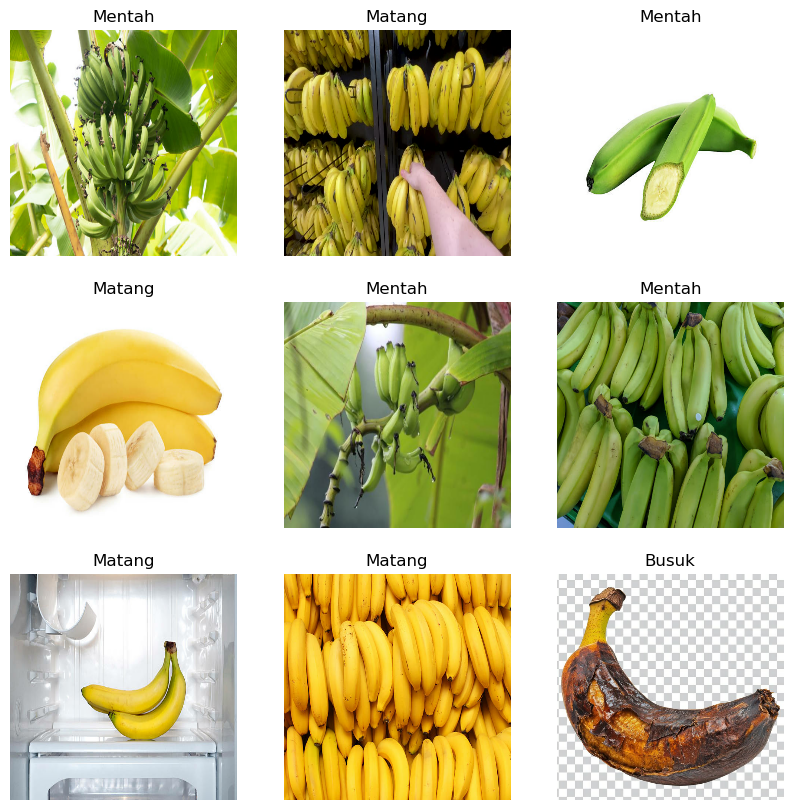

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

i = 0
for images, labels in train_ds.take(9):  # Take 9 batches, but each batch has only 1 image
    plt.subplot(3, 3, i+1)
    plt.imshow(images[0].numpy().astype('uint8'))  # Access the first (and only) image in the batch
    plt.title(class_names[labels[0].numpy()])  # Access the label directly (not using argmax)
    plt.axis('off')
    i += 1

plt.show()


In [6]:
for images, labels in train_ds.take(1):
    images_array = np.array(images)
    print(images_array.shape)
    

(8, 227, 227, 3)


In [7]:
import os
from PIL import Image


train_dir = "train_data" 

def check_invalid_images(directory):
    invalid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify() 
            except (IOError, SyntaxError):
                print(f"Gambar tidak valid: {file_path}")
                invalid_images.append(file_path)
    return invalid_images

invalid_images = check_invalid_images(train_dir)

if invalid_images:
    print("\nDaftar gambar tidak valid:")
    for img in invalid_images:
        print(img)
else:
    print("Semua gambar valid!")


Semua gambar valid!


In [8]:
import os
from PIL import Image

valid_formats = ['JPEG', 'PNG', 'GIF', 'BMP']

def check_invalid_images(directory):
    invalid_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    if img.format not in valid_formats:
                        print(f"Gambar tidak valid (format tidak didukung): {file_path}")
                        invalid_images.append(file_path)
            except (IOError, SyntaxError) as e:
                print(f"Gambar tidak valid: {file_path} - Error: {e}")
                invalid_images.append(file_path)
    return invalid_images

invalid_images = check_invalid_images("train_data")

if invalid_images:
    print("\nDaftar gambar tidak valid:")
    for img in invalid_images:
        print(img)
else:
    print("Semua gambar valid!")


Semua gambar valid!


C:\Users\HP\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train Images: 287
Validation Images: 31


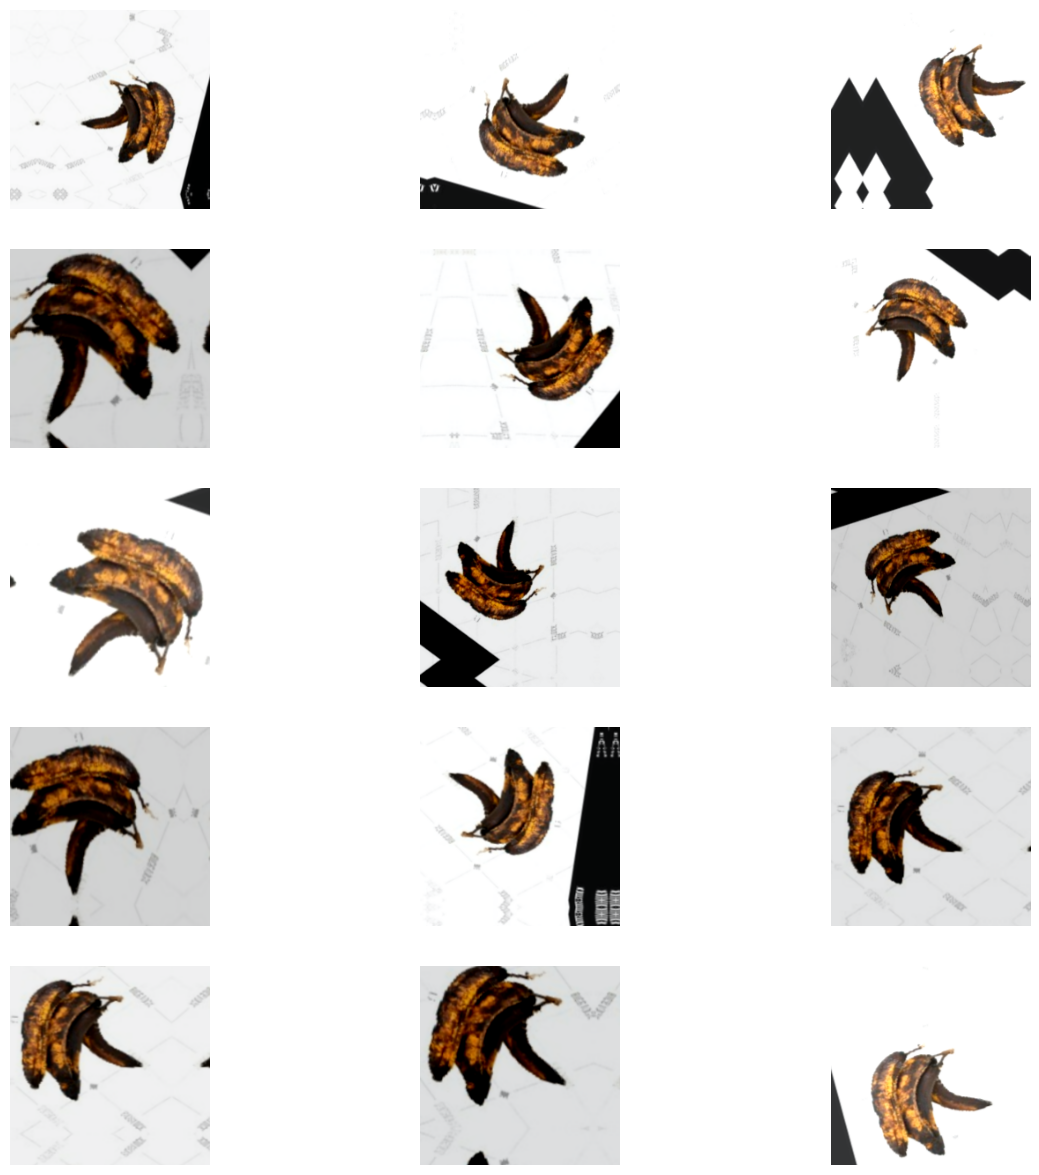

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt

Tuner = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=Tuner)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=Tuner)


data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_size, img_size, 3)),
    layers.RandomFlip("vertical"), 
    layers.RandomRotation(0.3),  
    layers.RandomZoom(0.3),  
    layers.RandomBrightness(0.3),  
    layers.RandomContrast(0.3),  
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
    layers.GaussianNoise(0.15),  
    layers.RandomCrop(height=img_size, width=img_size),  
])

train_count = sum(len(images) for images, _ in train_ds)
val_count = sum(len(images) for images, _ in val_ds)

print(f"Train Images: {train_count}")
print(f"Validation Images: {val_count}")

# Visualize more augmented images (e.g., 15 instead of 9)
plt.figure(figsize=(15, 15))

for images, labels in train_ds.take(69):  # Display a batch
    for i in range(15):  # Increase number of images shown
        augmented_image = data_augmentation(images)
        plt.subplot(5, 3, i + 1)  # Adjust subplot grid size for 15 images
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')

plt.show()


In [11]:
import tensorflow as tf
import keras
from keras._tf_keras.keras.backend import clear_session
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Input, Dense, Conv2D, Flatten, MaxPool2D, Dropout


def alexnet(input_shape, n_classes):
    input = Input(input_shape)


    x = Conv2D(96, 11, strides=4, padding='same', activation='relu')(input)
    x = MaxPool2D(3, strides=2)(x)
    

    x = Conv2D(256, 5, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
    

    x = Conv2D(384, 3, padding='same', activation='relu')(x)
    

    x = Conv2D(384, 3, padding='same', activation='relu')(x)
    

    x = Conv2D(256, 3, padding='same', activation='relu')(x)
    x = MaxPool2D(3, strides=2)(x)
    

    x = Flatten()(x)
    

    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)  
    

    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    
    output = Dense(n_classes, activation='softmax')(x)
    
    model = Model(input, output)
    return model


input_shape = (227, 227, 3)  
n_classes = 3 

clear_session()

model = alexnet(input_shape, n_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 227, 227, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 57, 57, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │        12,291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,293,635 (222.37 MB)

 Trainable params: 58,293,635 (222.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight




reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.2,          
    patience=10,         
    min_lr=0.00001        
)

model.compile(
    optimizer=Adam(learning_rate=0.001),  
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',  
    patience=10,            
    mode='max',             
    restore_best_weights=True  
)

history = model.fit(
    train_ds, 
    epochs=30, 
    validation_data=val_ds, 
    callbacks=[early_stopping, reduce_lr]  
)

Epoch 1/30


36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - accuracy: 0.2634 - loss: 360.9664 - val_accuracy: 0.3226 - val_loss: 1.1128 - learning_rate: 0.0010
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.3448 - loss: 1.1046 - val_accuracy: 0.2581 - val_loss: 4.5727 - learning_rate: 0.0010
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.3622 - loss: 1.2845 - val_accuracy: 0.2903 - val_loss: 1.1000 - learning_rate: 0.0010
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 345ms/step - accuracy: 0.3451 - loss: 1.1011 - val_accuracy: 0.3226 - val_loss: 1.1053 - learning_rate: 0.0010
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 359ms/step - accuracy: 0.3052 - loss: 1.1030 - val_accuracy: 0.2903 - val_loss: 1.1014 - learning_rate: 0.0010
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.3471 - loss: 1.0986 - val_accuracy: 0.2903 - val_loss: 1.1064 - learning_rate: 0.0010
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 0.3510 - loss: 1.0943 - va

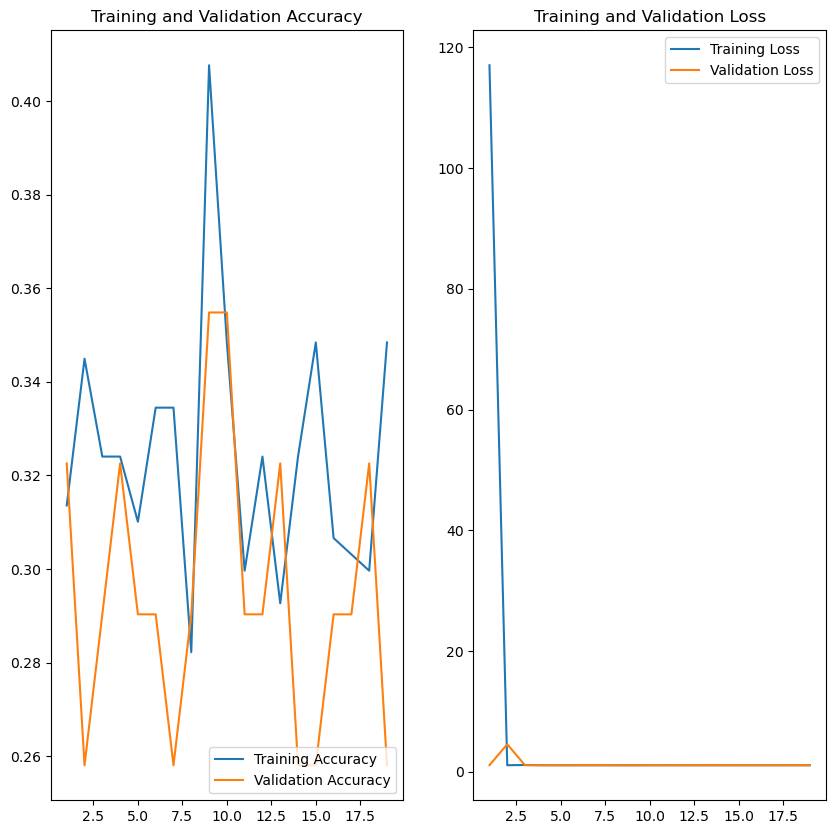

In [13]:

ephocs_range = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.plot(ephocs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(ephocs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(ephocs_range, history.history['loss'], label='Training Loss')
plt.plot(ephocs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [14]:
model.save('AlexNet.h5')

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from PIL import Image


model = load_model(r'AlexNet.h5')  
class_names = ['Matang', 'Mentah','Busuk']

def classify_images(image_path, save_path='predicted_image.jpg'):
    try:

        input_image = tf.keras.utils.load_img(image_path, target_size=(227, 227))
        input_image_array = tf.keras.utils.img_to_array(input_image)
        input_image_exp_dim = tf.expand_dims(input_image_array, 0)  # Add batch dimension


        predictions = model.predict(input_image_exp_dim)
        result = tf.nn.softmax(predictions[0])
        class_idx = np.argmax(result)
        confidence = np.max(result) * 100

        print(f"Prediksi: {class_names[class_idx]}")
        print(f"Confidence: {confidence:.2f}%")

        input_image = Image.open(image_path)
        input_image.save(save_path)

        return f"Prediksi: {class_names[class_idx]} dengan confidence {confidence:.2f}%. Gambar asli disimpan di {save_path}."
    except Exception as e:
        return f"Terjadi kesalahan: {e}"
result = classify_images(r'Prediksi\Matang\matang (1).jpg', save_path='matang1.jpg')
print(result)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Prediksi: Mentah
Confidence: 33.72%
Prediksi: Mentah dengan confidence 33.72%. Gambar asli disimpan di matang1.jpg.


Found 36 files belonging to 3 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 


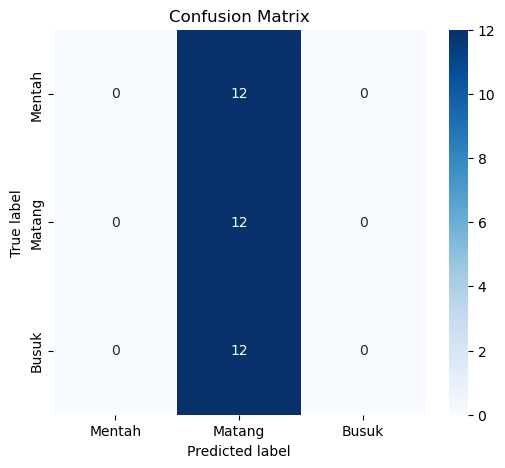

Confusion Matrix:
 [[ 0 12  0]
 [ 0 12  0]
 [ 0 12  0]]
Accuracy: 0.3333333333333333
Precision: [       nan 0.33333333        nan]
Recall: [0. 1. 0.]
F1 Score: [nan 0.5 nan]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
              precision    recall  f1-score   support

      Matang       0.00      0.00      0.00        12
      Mentah       0.33      1.00      0.50        12
       Busuk       0.00      0.00      0.00        12

    accuracy                           0.33        36
   macro avg       0.11      0.33      0.17        36
weighted avg       0.11      0.33      0.17        36



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import seaborn as sns
import matplotlib.pyplot as plt


test_data = tf.keras.preprocessing.image_dataset_from_directory(
    r'test_data',
    labels='inferred',
    label_mode='categorical',  
    batch_size=32,
    image_size=(227, 227)
)


y_pred = model.predict(test_data)
y_pred_class = tf.argmax(y_pred, axis=1) 


true_labels = []
for _, labels in test_data:
    true_labels.extend(tf.argmax(labels, axis=1).numpy()) 
true_labels = tf.convert_to_tensor(true_labels)


conf_mat = tf.math.confusion_matrix(true_labels, y_pred_class)
accuracy = tf.reduce_sum(tf.linalg.diag_part(conf_mat)) / tf.reduce_sum(conf_mat)

precision = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=0)
recall = tf.linalg.diag_part(conf_mat) / tf.reduce_sum(conf_mat, axis=1)

f1_score = 2 * (precision * recall) / (precision + recall)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat.numpy(), annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Mentah", "Matang","Busuk"], yticklabels=["Mentah", "Matang","Busuk"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Menampilkan hasil
###Terdapat code yang hilang disini! lihat modul untuk menemukanya
print("Confusion Matrix:\n", conf_mat.numpy())
print("Accuracy:", accuracy.numpy())
print("Precision:", precision.numpy())
print("Recall:", recall.numpy())
print("F1 Score:", f1_score.numpy())

from sklearn.metrics import classification_report

y_true = [np.argmax(labels.numpy(), axis=1) for _, labels in test_data]
y_true = np.concatenate(y_true)  # Flatten the list of arrays into a single array
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=class_names))